In [1]:
import subprocess
import pandas as pd
from cStringIO import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sb
import collections
import numpy as np
from scipy import stats
import matplotlib
from qvality import read_msgfp_csv, target_and_null_peptides_4_qvality, read_qvality_result
%matplotlib inline 

ImportError: No module named qvality

In [2]:
msgfplus = "/home/vitalv/cyano/label-free-demixq-diffacto-pipeline/msgfplus/"
qvality_dir = "/home/vitalv/cyano/label-free-demixq-diffacto-pipeline/qvality/"

#get msgfp peptides (Not PSM resulting from MSGFPlusAdapter) df filtered using qvality results:
msgfp_csv_files = [f for f in os.listdir(msgfplus) if f.endswith(".csv")]
run_prots = {} 
peptides = {}
for msgfp_csv in msgfp_csv_files:
    sample_name = msgfp_csv.split(".")[0] #msgfp_file_basename
    msgfp_psms = read_msgfp_csv(os.path.join(msgfplus, msgfp_csv))
    #psms collapsed to one (best scoring psm) peptide
    msgfp_peptides, msgfp_null_peptides = target_and_null_peptides_4_qvality(msgfp_psms) 
    #qvality_out_file = run_qvality(msgfp_file_basename, msgfp_peptides, msgfp_null_peptides)
    qvality_out_file = os.path.join(qvality_dir, (sample_name + "_qvality_out.csv"))
    msgfp_qvality = read_qvality_result(qvality_out_file)
    #ideally get one new df from qvality df and original peptides df by merging on score:
    #or I could just sort by score and add the qvalue column to the original peptides df
    msgfp_peptides = msgfp_peptides.sort_values(by='score')
    msgfp_peptides["qval"] = msgfp_qvality["q-value"].values
    #then filter q-val < 0.01 and decoy proteins
    msgfp_peptides = msgfp_peptides[msgfp_peptides["qval"]<0.01]
    msgfp_peptides = msgfp_peptides[~msgfp_peptides.accessions.str.contains('XXX')]
    #discard also all shared peptides by removing from the list all accessions that contain ";":
    msgfp_peptides = msgfp_peptides[~msgfp_peptides.accessions.str.contains(";")]
    print sample_name
    print("Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): %s"%len(msgfp_peptides))
    print("Unique proteins those peptides map to: %s\n"%len(msgfp_peptides.accessions.unique()))
    run_prots[sample_name] = list(msgfp_peptides.accessions.unique())
    peps = msgfp_peptides.groupby("accessions").size().value_counts().to_dict() # num of proteins with 1, 2, 3, ... peptides 
    peptides[sample_name] = peps

peptides = collections.OrderedDict(sorted(peptides.items()))

run_prots = collections.OrderedDict(sorted(run_prots.items()))
run_counts = {}
for run, prots in run_prots.items():
    run_counts[run] = len(prots)
run_counts = collections.OrderedDict(sorted(run_counts.items()))

Fusion_20161115_GM_u002_R2
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 8969
Unique proteins those peptides map to: 1953

Fusion_20161115_GM_u010_R2
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 8423
Unique proteins those peptides map to: 2022

Fusion_20161115_GM_u010_R3
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 8079
Unique proteins those peptides map to: 1965

Fusion_20161115_GM_u002_R3
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 10081
Unique proteins those peptides map to: 2072

Fusion_20161115_GM_u002_R1
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 9253
Unique proteins those peptides map to: 1992

Fusion_20161115_GM_u005_R1
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 9798
Unique proteins those peptides map to: 2053

Fusion_20161115_GM_u010_R1_2
Unique peptides (exclu

In [3]:
def autolabel(rects):
    # attach text label with bar height in barplot
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=9)


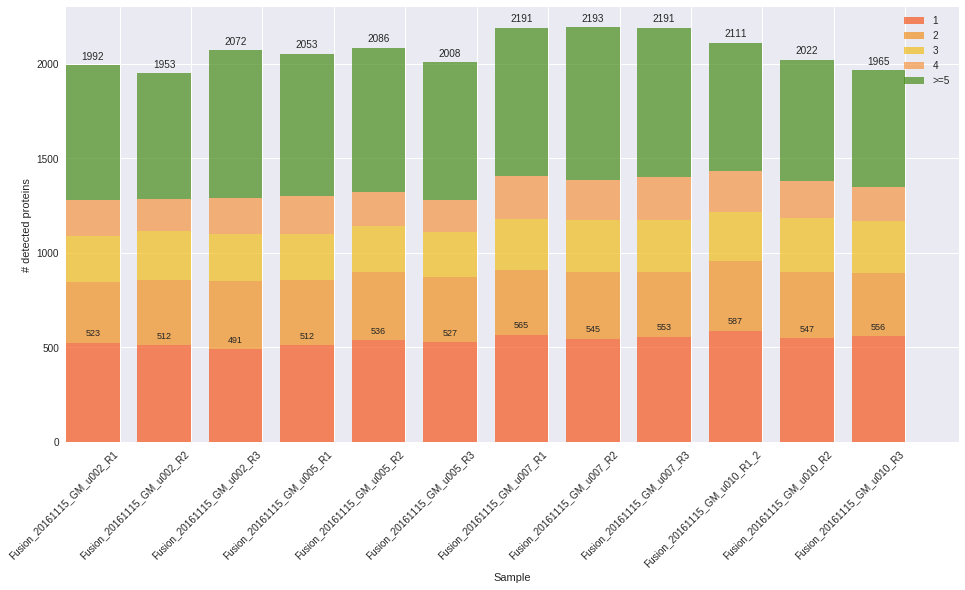

In [4]:
#Stacked bar plot showing number peptides supporting protein detection ######################################################
f, ax = plt.subplots(1, figsize=(16,8))
bar_width = 0.75
bar_l = [i+1 for i in range(len(run_counts))] # positions of the left bar-boundaries
tick_pos = [i+(bar_width/2) for i in bar_l] # positions of the x-axis ticks (center of the bars as bar labels)

one_pep_proteins = [peptides[k][1] for k in peptides.keys()]
two_pep_proteins = [peptides[k][2] for k in peptides.keys()]
one_and_two = [i+j for i,j in zip(one_pep_proteins,two_pep_proteins)]
three_pep_proteins = [peptides[k][3] for k in peptides.keys()]
one_two_three = [i+j for i,j in zip(one_and_two,three_pep_proteins)]
four_pep_proteins = [peptides[k][4] for k in peptides.keys()]
one_two_three_four = [i+j for i,j in zip(one_two_three,four_pep_proteins)]
more_than_four_pep_proteins = [sum(peptides[k].values()[4:]) for k in peptides.keys()]

rects1 = ax.bar(bar_l, one_pep_proteins, width=bar_width, label='1', alpha=0.7, color='#F4561D')
rects2 = ax.bar(bar_l, two_pep_proteins, width=bar_width, bottom=one_pep_proteins, label='2',\
                alpha=0.7, color='#F1911E')
rects3 = ax.bar(bar_l, three_pep_proteins, width=bar_width, bottom=one_and_two, label='3', \
                alpha=0.7, color='#F1BD1A')
rects4 = ax.bar(bar_l, four_pep_proteins, width=bar_width, bottom=one_two_three, label='4', \
                alpha=0.7, color='#f49542')
rects5 = ax.bar(bar_l, more_than_four_pep_proteins, width=bar_width, bottom=one_two_three_four, \
                label='>=5', alpha=0.7, color='#468c1a')

plt.xticks(tick_pos, run_counts.keys(), ha='right', rotation=45)
ax.set_ylabel("# detected proteins")
ax.set_xlabel("Sample")
plt.legend(loc='upper right')

plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width]) # Set a buffer around the edge

autolabel(rects1) #autolabel(rects2) #autolabel(rects3) #autolabel(rects4) #autolabel(rects5)

for bar in plt.bar(np.arange(len(run_counts)), run_counts.values(), alpha=0, width=0.75):
    height = bar.get_height()
    plt.text(bar.get_x() + 1 + bar.get_width()/2., 1.01*height, '%d'%int(height), ha='center', va='bottom', size=10)


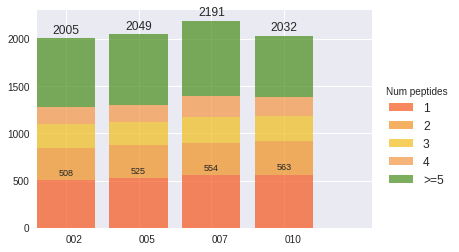

In [5]:
#instead of showing one bar for each individual replica, get on bar per sample averaging the 3 replica values:
f, ax = plt.subplots()#1, figsize=(12,10))
bar_width = 0.80
bar_l = range(1,5)
tick_pos = [i+(bar_width/2) for i in bar_l] 
one_pep_avg = [sum(one_pep_proteins[i:i+3])/3 for i in range(0, len(one_pep_proteins), 3)]
two_pep_avg = [sum(two_pep_proteins[i:i+3])/3 for i in range(0, len(two_pep_proteins), 3)]
one_two_avg = [i+j for i,j in zip(one_pep_avg,two_pep_avg)]
three_pep_avg = [sum(three_pep_proteins[i:i+3])/3 for i in range(0, len(three_pep_proteins), 3)]
one_two_three_avg = [i+j for i,j in zip(one_two_avg,three_pep_avg)]
four_pep_avg = [sum(four_pep_proteins[i:i+3])/3 for i in range(0,len(four_pep_proteins),3)]
one_two_three_four_avg = [i+j for i,j in zip(one_two_three_avg,four_pep_avg)]
more_than_four_pep_avg= [sum(more_than_four_pep_proteins[i:i+3])/3 for i in range(0,len(four_pep_proteins),3)]
rects1avg = ax.bar(bar_l, one_pep_avg, width=bar_width, label='1', alpha=0.7, color='#F4561D')
rects2avg = ax.bar(bar_l, two_pep_avg, width=bar_width, bottom=one_pep_avg, label='2', alpha=0.7, color='#F1911E')
rects3avg = ax.bar(bar_l, three_pep_avg, width=bar_width, bottom=one_two_avg, label='3', alpha=0.7, color='#F1BD1A')
rects4avg = ax.bar(bar_l, four_pep_avg, width=bar_width, bottom=one_two_three_avg, label='4', alpha=0.7, color='#f49542')
rects5avg = ax.bar(bar_l, more_than_four_pep_avg, width=bar_width, bottom=one_two_three_four_avg, label='>=5', alpha=0.7, color='#468c1a')
plt.xticks([1,2,3,4], ["002", "005", "007", "010"], ha='left')#, size=14)
legend = plt.legend(bbox_to_anchor=(1.01,0.7), title="Num peptides", prop={'size':12})
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width]) # Set a buffer around the edge
autolabel(rects1avg) #autolabel(rects2) #autolabel(rects3) #autolabel(rects4) #autolabel(rects5)
avg_prots_per_sample = [sum(run_counts.values()[i:i+3])/3 for i in range(0, len(run_counts.values()), 3)]
for bar in plt.bar(np.arange(len(rects1avg)), avg_prots_per_sample, alpha=0, width=0.75):
	height = bar.get_height()
	plt.text(bar.get_x() + 1 + bar.get_width()/2., 1.01*height, '%d'%int(height), ha='center', va='bottom', size=12)

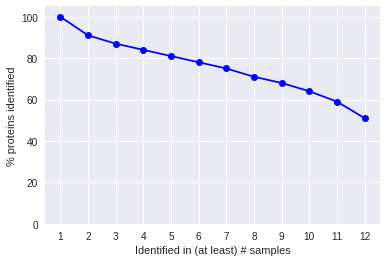

In [6]:
#Total (across all runs) proteins ########################################################################################
all_prots = []
all_prots = [prot for sublist in run_prots.values() for prot in sublist]
#remember I discarded all protein groups (groups of proteins containing more than one accession separated by ";")
prot_freq = collections.Counter(all_prots)
prot_count = collections.Counter(prot_freq.values())
p = prot_count.values()
prot_ids_in_runs = []
for i in range(len(p)):
	prot_ids_in_runs.append(sum([s for s in p[i:len(p)]]))
percent_prot_ids_in_runs = [i*100/max(prot_ids_in_runs) for i in prot_ids_in_runs]
plt.plot(percent_prot_ids_in_runs, "bo-")
plt.rcParams["figure.figsize"] = (16,8)
plt.ylim([0,105])
plt.xticks(range(len(percent_prot_ids_in_runs)), [i +1 for i in range(12)])
plt.xlabel("Identified in (at least) # samples")
plt.ylabel("% proteins identified")


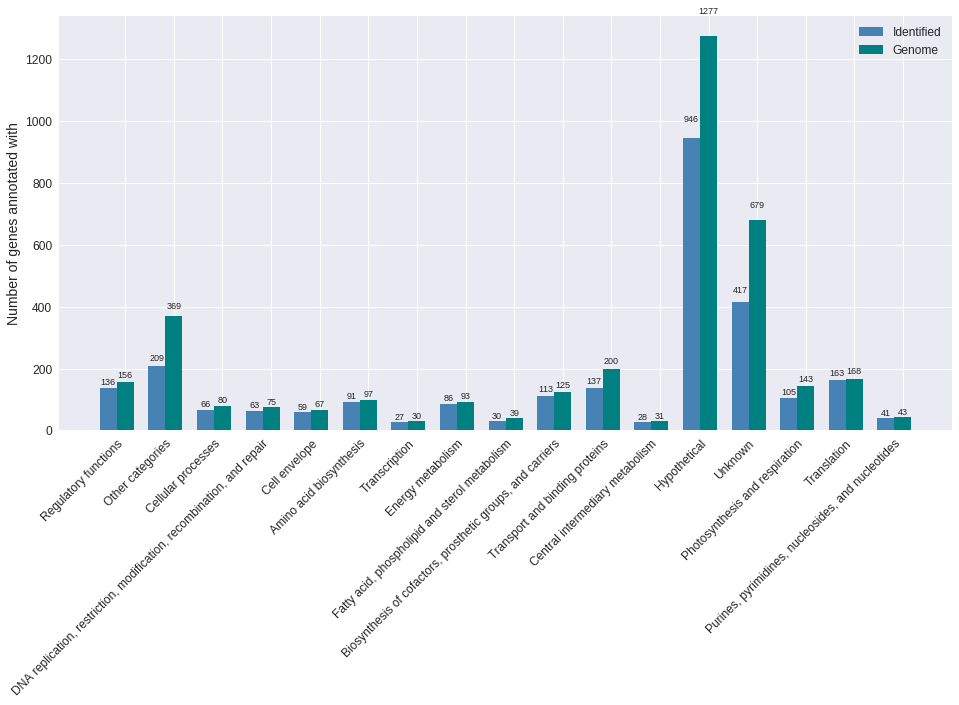

In [7]:
#Bar Plot categories of the detected proteins compared to categories of the whole genome ##################################
my_prots_categories = pd.DataFrame()
my_prots_categories["geneID"] = list(set(all_prots))
category_f = "/home/vitalv/cyano/category.txt"
category_df = pd.read_csv(category_f, delimiter="\t", header=None)
category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", \
                       "second_category_ID", "second_category_name"]
cols = ["geneID", "definition", "first_category_name", "second_category_name"]
my_prots_categories_df = pd.merge(my_prots_categories, category_df[cols], left_on='geneID', \
                                      right_on='geneID', how='left')
#Categories frequencies for identified set of proteins(genes) and for entire genome:
category_data_identified = my_prots_categories_df.groupby("first_category_name").size().to_dict()
category_data_genome = category_df.groupby("first_category_name").size().to_dict()

ind = np.arange(len(category_data_identified))  # the x locations for the groups
width = 0.35# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,12))
categories_identified, categories_genome = [], []
tick_labels = []
for cat, num in category_data_identified.items():
    categories_identified.append(category_data_identified[cat])
    categories_genome.append(category_data_genome[cat])
    tick_labels.append(cat)
rects1 = ax.bar(ind, categories_identified, width, color='steelblue')
rects2 = ax.bar(ind + width, categories_genome, width, color='teal')
ax.set_ylabel("Number of genes annotated with", fontsize=14)
ax.set_yticklabels(range(0,1400,200), fontsize=12)
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels, fontsize="12")
ax.legend((rects1[0], rects2[0]), ('Identified', 'Genome'), fontsize=12)
autolabel(rects1)
autolabel(rects2)
plt.gcf().subplots_adjust(bottom=0.4)
plt.xticks(ind+width, tick_labels, ha='right', rotation=45)
plt.show()

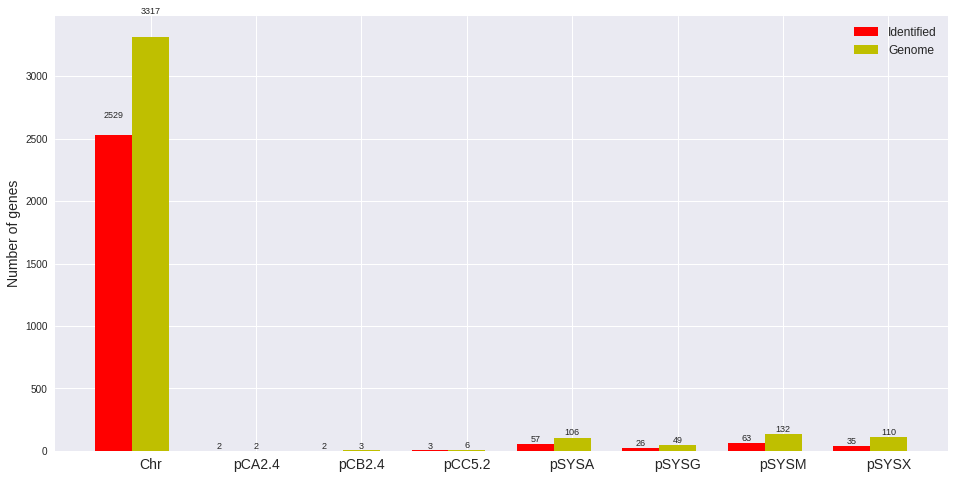

In [8]:
#Position frequencies (Chromosome or plasmids) ######################################################################################
genes = "/home/vitalv/cyano_dataset_20161118/genes.txt"
genes_df = pd.read_csv(genes, delimiter="\t", header=None)
genes_df.columns = ["DataSourceName", "geneID", "Chromosome", "Start", "Stop","Strand", "Description"]
identified = pd.DataFrame()
identified["geneID"] = list(set(all_prots))
identified_df = pd.merge(identified, genes_df, left_on='geneID', right_on='geneID', how='left')
location_data = identified_df.groupby("Chromosome").size().to_dict()
location_data = collections.OrderedDict(sorted(location_data.items()))
location_data_percent = [round(i*100/sum(location_data.values()),2) for i in location_data.values() ]
location_data_reference = genes_df.groupby("Chromosome").size().to_dict()
location_data_reference = collections.OrderedDict(sorted(location_data_reference.items()))
location_data_reference_percent = [round(i*100/sum(location_data_reference.values()),2) for i in location_data_reference.values() ]

ind = np.arange(len(location_data))  # the x locations for the groups
width = 0.35# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,8))
location_identified, location_genome = [], []
tick_labels = []
for loc, percent in location_data.items():
	location_identified.append(location_data[loc])
	location_genome.append(location_data_reference[loc])
	tick_labels.append(loc)
rects1 = ax.bar(ind, location_identified, width, color='r')
rects2 = ax.bar(ind + width, location_genome, width, color='y')
ax.set_ylabel("Number of genes", fontsize=14)
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels, fontsize=14)
ax.legend((rects1[0], rects2[0]), ('Identified', 'Genome'), fontsize=12)
autolabel(rects1)
autolabel(rects2)
plt.show()

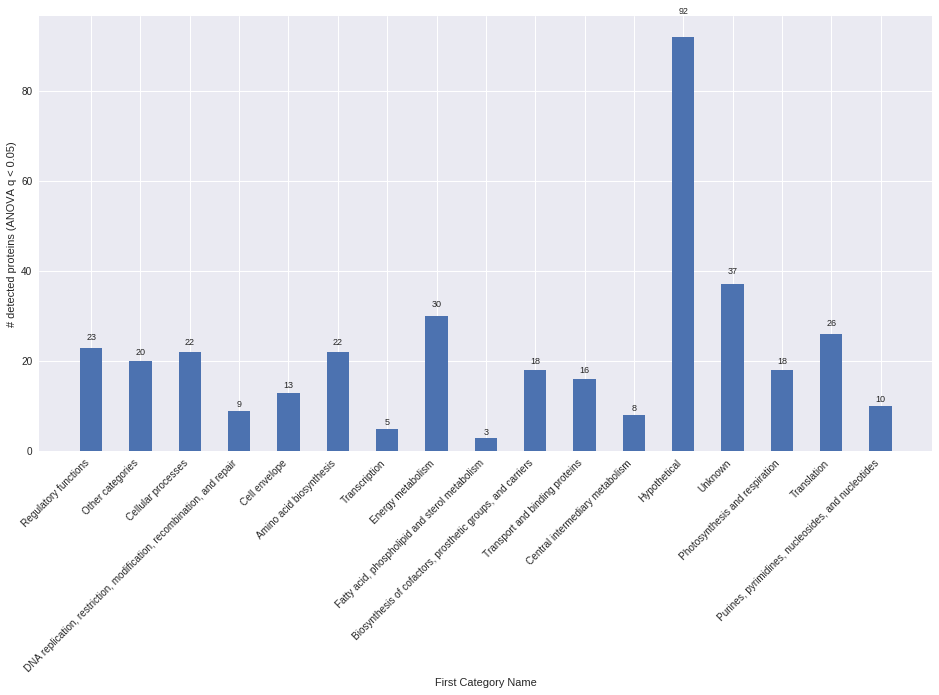

In [9]:
#One way ANOVA##############################################################################################################

diffacto_out = "/home/vitalv/cyano/label-free-demixq-diffacto-pipeline/diffacto_out.tsv"
diffacto = pd.read_csv(diffacto_out, delimiter="\t")
data = pd.merge(diffacto, genes_df[["geneID","Description"]], left_on="Protein", right_on="geneID", how='left')
data = data[data["S/N"] > -20]#Filter out non - informative proteins S/N greater than -20. See Diffacto manuscript
samples = [c for c in data.columns if c.startswith("0")]

num_samples = 4
num_replica = 3
for i in np.array(samples).reshape(num_samples, num_replica):
    #median = data[i].median(axis=1)
    avg = data[i].mean(axis=1)
    #data[i[0].split("_")[0]+"_median"] = median
    data[i[0].split("_")[0]+"_mean"] = avg

means = ["002_mean", "005_mean", "007_mean", "010_mean"]
data = data[["Protein"]+ samples + means]

for index, row in data.iterrows():
	#Get pandas df for each prot with columns dependent_variable, factor_1 and factor_2:
	prot_df = pd.DataFrame(columns=["dependent_variable", "group"])
	prot_df.group = [ s.split("_")[0] for s in samples ]
	prot_df.dependent_variable = row[samples].values
	k = len(pd.unique(prot_df.group))  # number of samples
	N = len(prot_df.values)  # samples times replica
	n = prot_df.groupby('group').size()[0] #num_replica
	DFbetween = k - 1
	DFwithin = N - k
	DFtotal = N - 1
	grand_mean = prot_df.dependent_variable.mean()
	SSbetween = sum( [ n * (prot_df[prot_df.group == g].dependent_variable.mean() - grand_mean)**2 for g in set(list(prot_df.group))] )
	sum_y_squared = sum([value**2 for value in prot_df['dependent_variable'].values])
	SSwithin = sum_y_squared - sum(prot_df.groupby('group').sum()['dependent_variable']**2)/n
	SStotal = sum_y_squared - (prot_df['dependent_variable'].sum()**2)/N
	MSbetween = SSbetween/DFbetween
	MSwithin = SSwithin/DFwithin
	F = MSbetween/MSwithin
	p = stats.f.sf(F, DFbetween, DFwithin)
	data.loc[index, 'p_val'] = p

#Convert p-values to q-values:
#1 write p-values to a .txt
data.p_val.to_csv("anova_p_values.txt", index=False)
#2 run qvality
qvality_cmd = "qvality anova_p_values.txt -o anova_qvality_out.txt"
proc = subprocess.Popen(qvality_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
out,err = proc.communicate()
#3 read qvality output 
with open('anova_qvality_out.txt') as f:
	lines = f.readlines()
qvalues = [line.rstrip('\n').split("\t")[-1] for line in open('anova_qvality_out.txt')][1:]
#4 append qvalues to my data df
data = data.sort_values(by='p_val')
data["q_val"] = [float(q) for q in qvalues]

#category_f = "/home/vitalv/cyano/category.txt"
#category_df = pd.read_csv(category_f, delimiter="\t", header=None)
#category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
category_cols = ["geneID", "definition", "first_category_name", "second_category_name"]
data = pd.merge(data, category_df[category_cols], left_on="Protein", right_on="geneID", how='left')

data.Protein = [p.split(";")[0] for p in data.Protein]
data_anova = data[data["q_val"] < 0.05] 

category_data_anova = data_anova.groupby("first_category_name").size().to_dict()

index = np.arange(1,len(set(data_anova.first_category_name)))
counts = category_data_anova.values()
width = 0.45
plt.xlabel("First Category Name")
plt.xticks(index, category_data_anova.keys(),  ha='right', rotation=45)
plt.ylabel("# detected proteins (ANOVA q < 0.05)")
bars = plt.bar(index, counts, width)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=9)

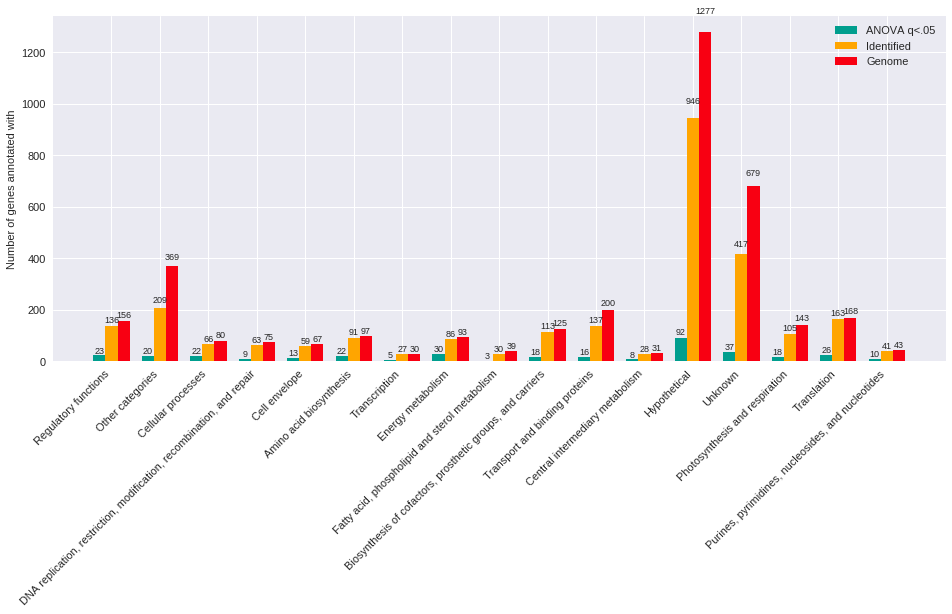

In [11]:
#Category Bar Plot with 3 bars per category: ANOVA q < 05 proteins, Detected Proteins, Genome ###############################
del category_data_genome["RNA"]
ind = np.arange(len(category_data_genome))  # the x locations for the groups
width = 0.25# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,10))
categories_anova, categories_identified, categories_genome = [], [], []
tick_labels = []
for cat, num in category_data_genome.items():
	categories_anova.append(category_data_anova[cat])
	categories_identified.append(category_data_identified[cat])
	categories_genome.append(category_data_genome[cat])
	tick_labels.append(cat)
rects1 = ax.bar(ind , categories_anova, width, color='#009E8E')
rects2 = ax.bar(ind + width, categories_identified, width, color='#FFA500')
rects3 = ax.bar(ind + 2*width, categories_genome, width, color='#F80012')
ax.set_ylabel("Number of genes annotated with", fontsize=11)
ax.set_yticklabels(range(0,1400,200), fontsize=11)
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels, rotation=90, fontsize=11)
ax.legend((rects1[0], rects2[0], rects3[0]), ('ANOVA q<.05', 'Identified', 'Genome'), fontsize=11)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.gcf().subplots_adjust(bottom=0.4)
plt.xticks(ind+width, tick_labels,  ha='right', rotation=45)
plt.show()

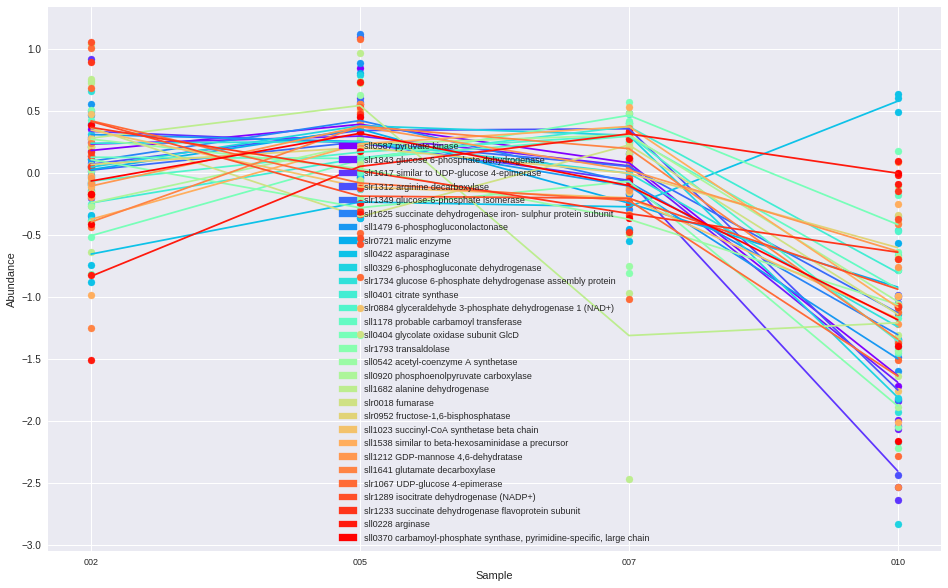

In [12]:
#PLOT abundance vs sample for different subsets of proteins:################################################################
import matplotlib.patches as mpatches

def abundance_plot(category):
    protein_set = data_anova[data_anova["first_category_name"] == category]
    X = [1,2,3,4]
    x_labels = set([c.split("_")[0] for c in samples])
    nCols = len(X)
    color_patches = []
    fig, ax = plt.subplots(1, figsize=(16,10))
    color=iter(plt.cm.rainbow(np.linspace(0,1,len(protein_set))))
    for i, row in protein_set.iterrows():
        prot_acc = row.Protein
        prot_descr = row.definition
        Ys = row[samples].values.reshape(4,3).T #for scatter
        #boxes = [a for a in row[samples].values.reshape(4,3).astype(float)]
        nRows = Ys.shape[0]
        Xs=X*nRows
        c = next(color)
        ax.plot(X, row[means].values, "-", color=c)
        ax.scatter(Xs, Ys.flatten(), color=c)
        #bp = plt.boxplot(boxes, whis='range')
        #plt.setp(bp['boxes'], color=c)
        #thick line imitating a box instead of boxplot?:
        #plt.plot((x1, x2), (y1, y2), 'k-')
        patch = mpatches.Patch(color=c, label=prot_acc + " " + prot_descr)
        color_patches.append(patch)
    ax.set_ylabel("Abundance", fontsize=11)
    ax.set_xlabel("Sample", fontsize=11)
    ax.set_title("", fontsize=11)
    ax.set_xticks(X)
    ax.set_xticklabels(sorted(list(x_labels)), fontsize=9)
    plt.legend(handles=color_patches, loc=0,   fontsize=9)
    
abundance_plot("Energy metabolism")

In [13]:
#Gene Annotation Enrichment #################################################################################################
def enrich(input_gene_list, background_gene_list):
    category_f = "/home/vitalv/cyano/category.txt"
    category_df = pd.read_csv(category_f, delimiter="\t", header=None, \
    names=["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"])
    data = category_df[category_df["geneID"].isin(input_gene_list)]
    background = category_df[category_df["geneID"].isin(background_gene_list)]
    print "first_category_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + \
    "\t" + "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value"
    for category in data.first_category_name.unique():
        k = len(data) #input list (list of differentially abundant proteins -ANOVA<0.05-)
        x = len(data[data.first_category_name == category]) #num of genes in the input list with the annotation
        N = len(set(background_gene_list)) #background number of genes. 
        m = len(background[background.first_category_name == category])
        p = stats.hypergeom.sf(x, N, k, m)
        print category + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p)

enrich(list(data.geneID), set(all_prots))

first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Amino acid biosynthesis	60	973	91	2717	7.35140656231e-10
Biosynthesis of cofactors, prosthetic groups, and carriers	47	973	113	2717	0.0804178252749
Cell envelope	37	973	59	2717	5.95410352239e-06
Cellular processes	40	973	66	2717	9.66099919551e-06
Central intermediary metabolism	17	973	28	2717	0.00192925954538
Energy metabolism	55	973	86	2717	1.90009238025e-08
Fatty acid, phospholipid and sterol metabolism	16	973	30	2717	0.0153188366843
Photosynthesis and respiration	43	973	105	2717	0.111127014059
Purines, pyrimidines, nucleosides, and nucleotides	23	973	41	2717	0.00233499540024
Regulatory functions	44	973	136	2717	0.778768572382
DNA replication, restriction, modification, recombination, and repair	23	973	63	2717	0.397204700836
Transcription	16	973	27	2717	0.00356014606383
Translation	87	973	163	2717	7.81716335992e-07
Transport and bindi

In [14]:
def correct_pvalues_for_multiple_testing(pvalues, correction_type = "Benjamini-Hochberg"):              
    pvalues = np.array(pvalues)
    n = float(pvalues.shape[0])
    new_pvalues = np.empty(pvalues.shape[0])
    if correction_type == "Bonferroni":
        new_pvalues = n * pvalues
    elif correction_type == "Bonferroni-Holm":
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
        values.sort()
        for rank, vals in enumerate(values):
            pvalue, i = vals
            new_pvalues[i] = (n-rank) * pvalue
    elif correction_type == "Benjamini-Hochberg":
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
        values.sort()
        values.reverse()
        new_values = []
        for i, vals in enumerate(values):
            rank = n - i
            pvalue, index = vals
            new_values.append((n/rank) * pvalue)
        for i in xrange(0, int(n)-1):
            if new_values[i] < new_values[i+1]:
                new_values[i+1] = new_values[i]
        for i, vals in enumerate(values):
            pvalue, index = vals
            new_pvalues[index] = new_values[i]
    return new_pvalues

In [15]:
def enrichGO(input_gene_list, background_gene_list, ontology):
    '''
    #ontology is one of : Biological Process, Molecular Function or Cellular Component
    '''
    go_terms_f = "/home/vitalv/cyano/label-free-demixq-diffacto-pipeline/goterm.txt"
    go_df = pd.read_csv(go_terms_f, delimiter="\t", header=None, names=["species", "geneID", "annotation_type", "go_term"])
    data_go = go_df[go_df["geneID"].isin(input_gene_list)]
    data = data_go[data_go.go_term.str.contains(ontology, case=False)]
    background = go_df[go_df["geneID"].isin(set(all_prots))]
    background = background[background.go_term.str.contains(ontology, case=False)]
    #print "GO_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + "\t" \
    #+ "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value"
    enrichGO_pvalues = []
    with open("enrichGO.txt", "wb") as f:
        f.write("GO_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + "\t" + \
                "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value" + "\n")
        for annotation in data.go_term.unique():
            k = len(data.geneID.unique())
            x = len(data[data.go_term == annotation])
            N = len(set(all_prots))
            m = len(background[background.go_term == annotation])
            p = stats.hypergeom.sf(x, N, k, m)
            #print annotation + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p)
            enrichGO_pvalues.append(p)
            f.write(annotation + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p) + "\n")
    return enrichGO_pvalues

In [16]:
import statsmodels.sandbox.stats.multicomp as mc
from IPython.display import display, HTML

enrichGO_pvalues = enrichGO(list(data.geneID), set(all_prots), "biological process")
enrichGO_df = pd.read_csv("enrichGO.txt", delimiter="\t")

'''
http://statsmodels.sourceforge.net/devel/generated/statsmodels.sandbox.stats.multicomp.multipletests.html

statsmodels.sandbox.stats.multicomp.multipletests(pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

method is one of:
`bonferroni` : one-step correction
`sidak` : one-step correction
`holm-sidak` : step down method using Sidak adjustments
`holm` : step-down method using Bonferroni adjustments
`simes-hochberg` : step-up method  (independent)
`hommel` : closed method based on Simes tests (non-negative)
`fdr_bh` : Benjamini/Hochberg  (non-negative)
`fdr_by` : Benjamini/Yekutieli (negative)
`fdr_tsbh` : two stage fdr correction (non-negative)
`fdr_tsbky` : two stage fdr correction (non-negative)
'''

reject, adj_pvalues, corrected_a_sidak, corrected_a_bonf =  mc.multipletests(enrichGO_df["p-value"], method='fdr_bh')
enrichGO_df["adj_pval"] = adj_pvalues
HTML(enrichGO_df.to_html())

,GO_annotation,Genes in input list w/ annotation,Genes in input list,Genes in background list w/ annotation,Genes in background list,p-value,adj_pval
0,Biological Process: biosynthetic process (GO:0...,43,621,71,2717,8.909273e-13,1.795053e-12
1,Biological Process: peptidoglycan turnover (GO...,1,621,2,2717,5.217517e-02,6.279490e-02
2,Biological Process: glycolysis (GO:0006096),7,621,12,2717,1.456231e-03,2.539069e-03
3,Biological Process: metabolic process (GO:0008...,134,621,254,2717,1.209479e-28,2.473521e-28
4,Biological Process: isoprenoid biosynthetic pr...,4,621,6,2717,2.996537e-03,5.126152e-03
5,Biological Process: oxidation reduction (GO:00...,88,621,171,2717,6.680413e-18,1.356024e-17
6,Biological Process: nucleotide-excision repair...,3,621,5,2717,1.107947e-02,1.741975e-02
7,Biological Process: protein metabolic process ...,6,621,7,2717,3.174208e-05,6.037654e-05
8,Biological Process: activation of protein kina...,1,621,2,2717,5.217517e-02,6.279490e-02
9,Biological Process: methylglyoxal biosynthetic...,1,621,1,2717,0.000000e+00,0.000000e+00


### Hierarchical Clustering

for the point:  
(xa, ya, za)  
(xb, yb, zb)  
the euclidean distance is:   
euclidean_dist = sqrt((xa-xb)^2 + (ya-yb)^2 + (za-zb)^2)  
pdist is equivalent to : [np.sqrt(np.sum((matrix[0]-matrix[1])**2)), np.sqrt(np.sum((matrix[0]-matrix[2])**2)), ... ]  

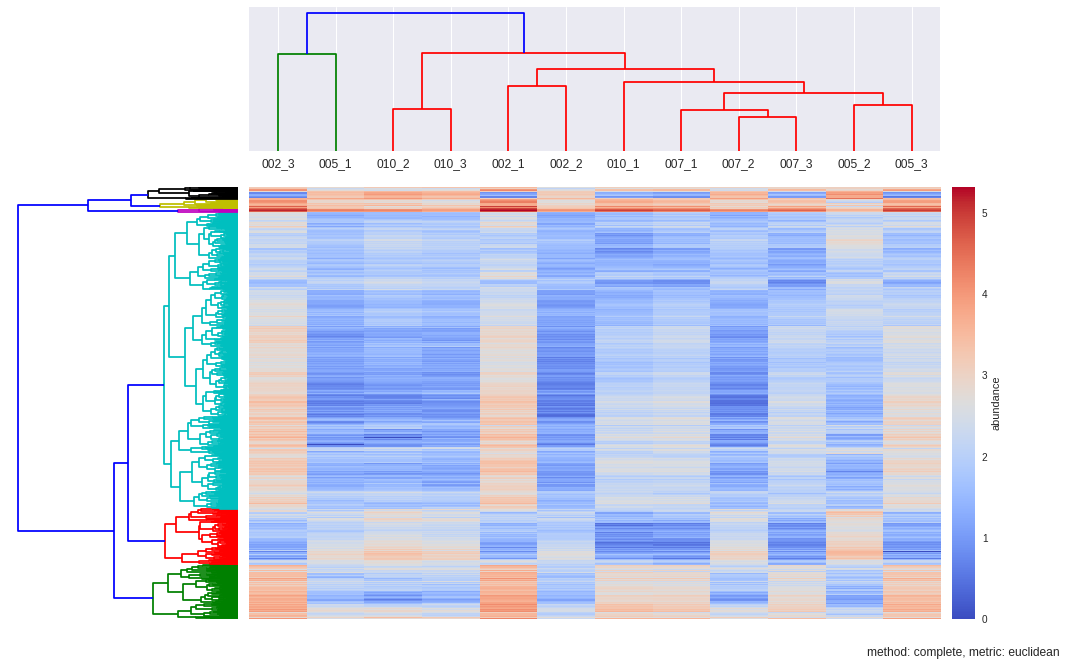

In [17]:
#HIERARCHICAL CLUSTER ANALYSYS #############################################################################################
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
#diffacto_out = "/home/vitalv/cyano/label-free-demixq-diffacto-pipeline/diffacto_out.tsv"
#diffacto = pd.read_csv(diffacto_out, delimiter="\t")
#data = diffacto[diffacto["S/N"] > -20]
#samples = ["002_1", "002_2", "002_3", "005_1", "005_2", "005_3", "007_1", "007_2", "007_3", "010_1", "010_2", "010_3"]
#convert back to linear space:
#data[samples] = 2 ** data[samples]
matrix = 2**data[samples].values

 
#http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python/
def hcluster(matrix, method='complete', metric='euclidean', dendro_color_threshold=0.45):
    fig = plt.figure(figsize=(16,10))
    #First dendrogram. Rows. Genes.
    D = dist.pdist(matrix, metric=metric) #Pairwise distances between observations in n-dimensional space.
    D = dist.squareform(D)
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    Y = sch.linkage(D, method=method, metric=metric)
    Z1 = sch.dendrogram(Y, orientation='left', color_threshold=dendro_color_threshold*max(Y[:,2])) 
    #colors all descendent links below a cluster node k the same color if k is the first node below the cut threshold
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axis('off')
    #Second dendrogram. Columns. Samples
    D_samples = dist.pdist(matrix.T, metric=metric)
    D_samples = dist.squareform(D_samples)
    ax2 = fig.add_axes([0.3,0.75,0.6,0.2])
    Y = sch.linkage(D_samples, method=method, metric=metric)
    #for label in ax2.get_xticklabels(): label.set_rotation(45) 
    Z2 = sch.dendrogram(Y, labels=samples, color_threshold=max(Y[:,2]))
    #ax2.set_xticks([])
    ax2.set_yticks([])
    #remove outer border(frame)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Scale the max and min colors so that 0 is white/black
    cmap=plt.cm.coolwarm #plt.cm.YlGnBu
    vmin = matrix.min()
    vmax = matrix.max()
    vmax = max([vmax,abs(vmin)])
    vmin = vmax*-1
    norm = matplotlib.colors.Normalize(vmin/2, vmax/2)
    # Plot heatmap
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    heatmap = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=cmap)#, norm=norm) #use norm if values are log
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])
    heatmap
    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    colorbar = plt.colorbar(heatmap, cax=axcolor)
    colorbar.set_label("abundance")
    plt.title("method: %s, metric: %s"%(method,metric), x=0.5, y=-0.1)
    return Z1, Z2, heatmap
   


dendroRows_com_euc, dendroCols, heatmap = hcluster(matrix, method='complete', metric='euclidean', dendro_color_threshold=0.45)


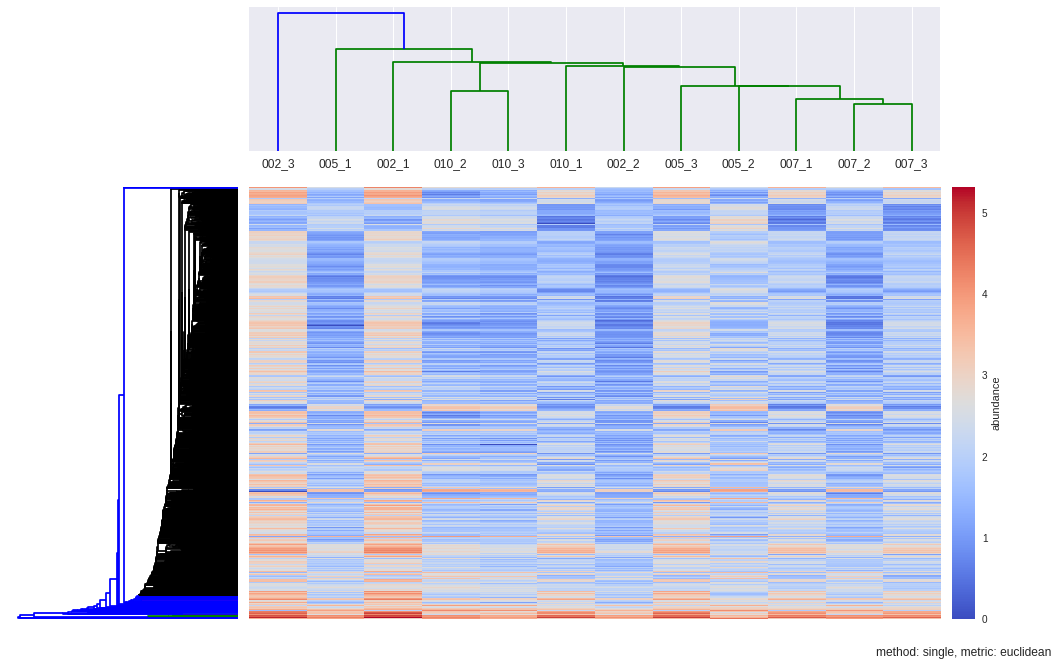

In [95]:
#OTHER DENDROGRAM METHODS AND METRICS 

dendroRows_sin_euc, dendroCols, heatmap = hcluster(matrix, method='single', metric='euclidean', dendro_color_threshold=0.45)


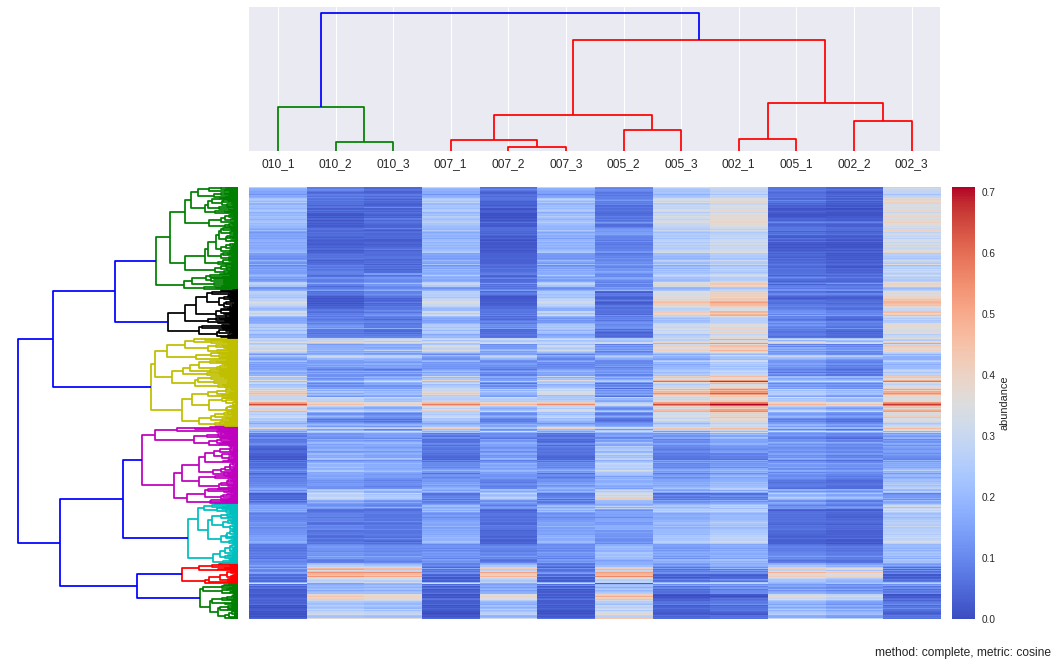

In [18]:
dendroRows_com_cos, dendroCols, heatmap = hcluster(matrix, method='complete', metric='cosine', dendro_color_threshold=0.45)


In [19]:
#GO enrichment on the clusters ################
from collections import defaultdict

def cluster_enrich(dendroRows, collapse=False):
    
    #see http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python
    cluster_idxs = defaultdict(list)
    for c, pi in zip(dendroRows['color_list'], dendroRows['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    #for  color_threshold=0.45*max(Y[:,2]) in the proteins(rows) dendrogram I get 
    #6 clusters but 3 of them are quite small. One option is to just group them:
    if collapse:
        small_cluster, small_cluster_idxs = [], []
        for color, idxs in cluster_idxs.iteritems():
            if len(idxs) < 30:
                small_cluster.append(color)
                small_cluster_idxs.append(idxs)
        for color in small_cluster: cluster_idxs.pop(color)
        cluster_idxs[''.join(small_cluster)] = [item for sublist in small_cluster_idxs for item in sublist]


    for color, idxs in cluster_idxs.iteritems():
        cluster_proteins = list(data.iloc[cluster_idxs[color],:].Protein)
        cluster_proteins = [protein for protein in cluster_proteins if ";" not in protein]
        print "CLUSTER: %s" % color + " (%s proteins)" %  len(cluster_proteins)
        enrich(cluster_proteins, set(all_prots))
        print "\n"

        

cluster_enrich(dendroRows_com_cos, collapse=False)
        

CLUSTER: c (136 proteins)
first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Amino acid biosynthesis	10	136	91	2717	0.00497117924501
Biosynthesis of cofactors, prosthetic groups, and carriers	11	136	113	2717	0.00962897610251
Cell envelope	6	136	59	2717	0.0260312182659
Cellular processes	9	136	66	2717	0.00134836933099
Central intermediary metabolism	2	136	28	2717	0.162218659253
Energy metabolism	11	136	86	2717	0.000955631559779
Fatty acid, phospholipid and sterol metabolism	1	136	30	2717	0.447892614187
Photosynthesis and respiration	8	136	105	2717	0.0767280419821
Purines, pyrimidines, nucleosides, and nucleotides	5	136	41	2717	0.0148889727761
Regulatory functions	8	136	136	2717	0.238062909861
DNA replication, restriction, modification, recombination, and repair	2	136	63	2717	0.619415504678
Transcription	2	136	27	2717	0.150015838386
Translation	7	136	163	2717	0.577917622949
Transport and 

### K Means

separate samples in n groups of equal variance

first step chooses the initial centroids (k, the number of clusters)

After initialization, K-means consists of looping between the two other steps:

The first step assigns each sample to its nearest centroid.

The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid

The inertia or within-cluster sum-of-squares is minimized

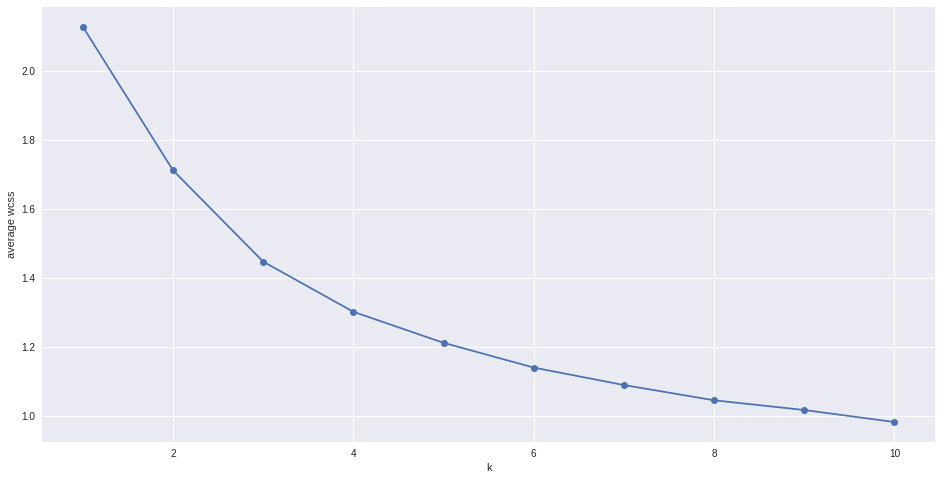

In [20]:
#OTHER CLUSTERING METHODS BESIDES HCL: K-MEANS AND MEAN SHIFT ##############################################################
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist,cdist

#diffacto_out = "/home/vitalv/cyano/label-free-demixq-diffacto-pipeline/diffacto_out.tsv"
#diffacto = pd.read_csv(diffacto_out, delimiter="\t")
#data = diffacto[diffacto["S/N"] > -20]
#samples = ["002_1", "002_2", "002_3", "005_1", "005_2", "005_3", "007_1", "007_2", "007_3", "010_1", "010_2", "010_3"]
#data[samples] = 2 ** data[samples] #convert back to linear space, diffacto output is log2
matrix = 2**data[samples].values


#K-MEANS
# Try to find  optimal number of clusters for k-means. "Elbow" method
k_range = range(1,11)
k_means = [KMeans(n_clusters = k, init='k-means++').fit(matrix) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means]
labels = [X.labels_ for X in k_means]
#calculate Euclidean distance from each point to cluster center
k_euclid = [cdist(matrix, c, 'euclidean') for c in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
#Total within cluster sum of squares
wcss = [sum(d**2) for d in dist]
#average wcss
avwcss = [(sum(d**2))/len(d) for d in dist]
#total sum of squares
tss = sum(pdist(matrix)**2)/matrix.shape[0]
#between cluster sum of squares:
bss = tss - wcss
#plot average wcss vs number of clusters "Elbow plot": look for a point where the rate of decrease in wcss sharply shifts
plt.plot(k_range, avwcss, '-o')
plt.ylabel("average wcss")
plt.xlabel("k")

#### Silhouette plots

The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters. Provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters.

A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters 

and negative values indicate that those samples might have been assigned to the wrong cluster.

The Silhouette Coefficient is calculated using the mean intra-cluster distance **(a)** and the mean nearest-cluster distance **(b)** for each sample. The Silhouette Coefficient for a sample is **(b - a) / max(a, b)**

In [21]:
def cluster_abundance(protein_idxs, ax=None):
    protein_set = data[data["Protein"].isin(data.iloc[idxs, :].Protein)]
    X = [1,2,3,4]
    x_labels = set([c.split("_")[0] for c in samples])
    nCols = len(X)
    color_patches = []
    if not ax: fig, ax = plt.subplots()
    color=iter(plt.cm.rainbow(np.linspace(0,1,len(protein_set))))
    for i, row in protein_set.iterrows():
        Ys = row[samples].values.reshape(4,3).T #for scatter
        nRows = Ys.shape[0]
        Xs=X*nRows
        ax.plot(X, row[means].values, "-", color='gray')
    medians = protein_set[means].median(axis=0)
    ax.plot(X, medians, "-", color='red')
    ax.set_ylabel("Abundance", fontsize=9)
    ax.set_xlabel("Sample", fontsize=9)
    ax.set_title("", fontsize=10)
    ax.set_xticks(X)
    ax.set_xticklabels(sorted(list(x_labels)), fontsize=9)

n_clusters: 2 Average silhouette_score is : 0.185305484063
n_clusters: 3 Average silhouette_score is : 0.195025791161
n_clusters: 4 Average silhouette_score is : 0.178523494958
n_clusters: 5 Average silhouette_score is : 0.158383531414
n_clusters: 6 Average silhouette_score is : 0.14186245441


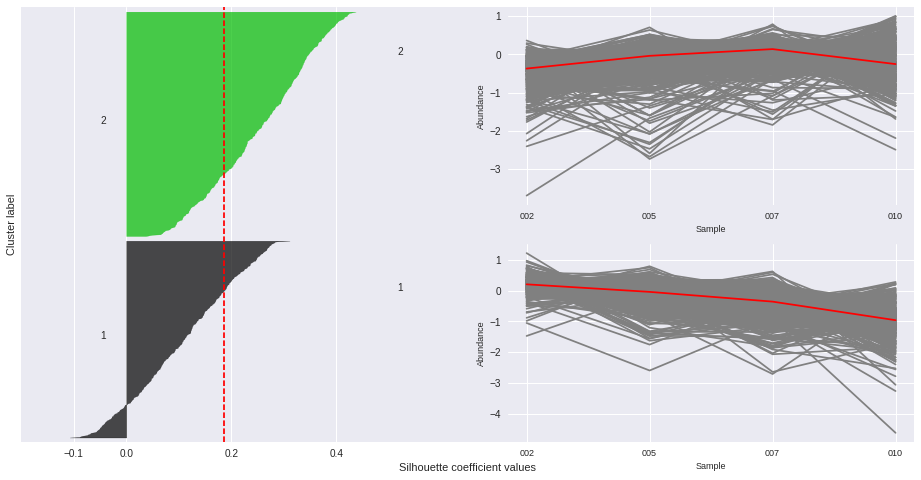

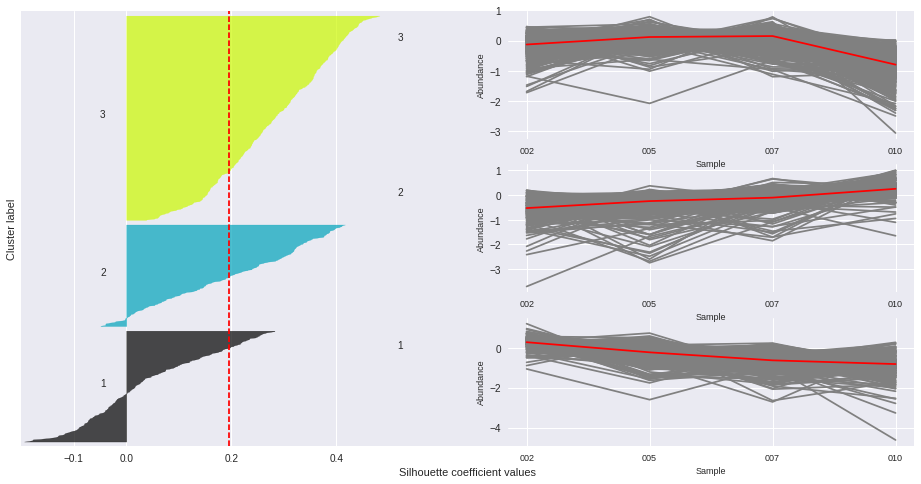

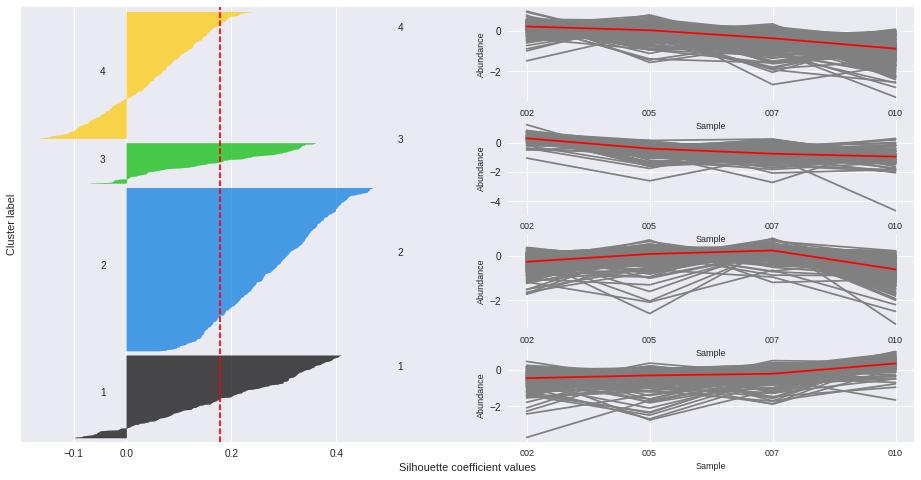

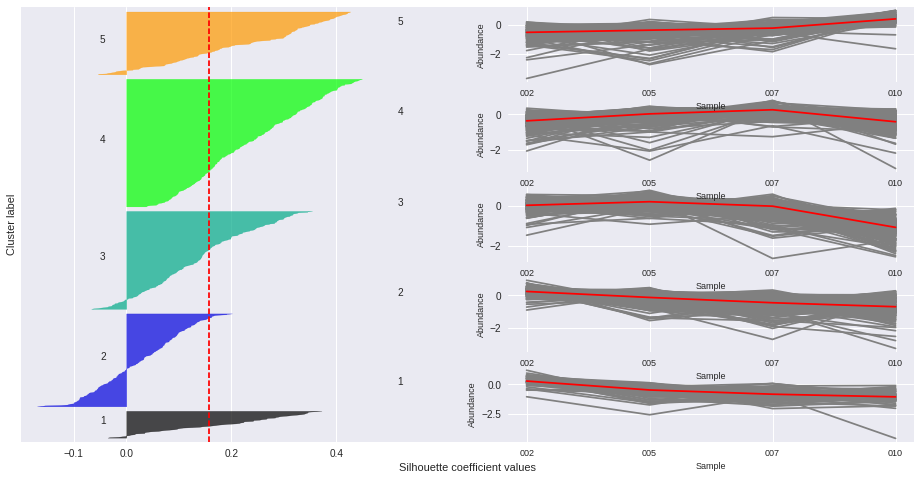

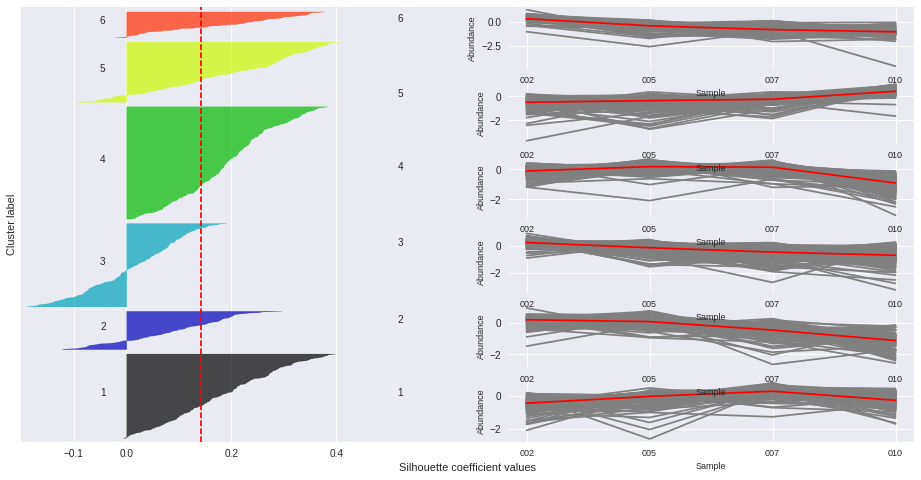

In [31]:
#Silhouette coefficients and cluster abundance plots ------------------------------------------------------------------------
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
range_n_clusters = range(2,7)
for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(figsize=(16,8))
    #fig, (ax1, ax2) = plt.subplots(1, 2) # Create a subplot with 1 row and 2 columns
    ax1.set_xlim([-0.2, 1.5]) 
    ax1.set_ylim([0, len(matrix) + (n_clusters + 1) * 10]) #inserts blank space between silhouette plots of individual cluster
    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++')#, random_state=10) 
    cluster_labels = kmeans.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, cluster_labels) # The silhouette_score gives the average value for all the samples.
    print "n_clusters:", n_clusters, "Average silhouette_score is :", silhouette_avg
    sample_silhouette_values = silhouette_samples(matrix, cluster_labels) # Compute the silhouette scores for each sample
    cluster_idxs = {}
    y_lower = 10
    for i in range(n_clusters):
        c = cluster_labels == cluster
        cluster_idxs[cluster] = np.where(c == True)
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]# Aggregate silhouette scores
        ith_cluster_silhouette_values.sort() # and sort them
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # # Compute the new y_lower for next plot 10 for the 0 samples
        position=range(n_clusters)[-(i+1)]*2+2
        ax_n = fig.add_subplot(n_clusters,2,position) #add_subplot(rows,columns,positionInGrid)
        ax_n.text(-0.05,0,str(i+1))
        idxs = list(cluster_idxs[i][0])
        cluster_abundance(idxs, ax=ax_n)
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")# Vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4])

### Mean Shift

Mean shift has the advantage that it does not require a pre-defined number of clusters

Updates centroid candidates in each iteration so they become the mean of the points within a region of size determined 
by the paramater **bandwidth**

The mean shift vector is computed for each centroid and points towards a region of the maximum increase in the density of points

In [24]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(matrix, quantile=0.3, n_samples=980) #default: quantile=0.3, n_samples= (all samples are used)
#quantile=0.5 means that the median of all pairwise distances is used
#but it takes a default value if bandwidth is not set

ms = MeanShift(bandwidth=bandwidth)

ms.fit(matrix)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

cluster_idxs = {}
for cluster in range(n_clusters_):
    c = labels == cluster
    cluster_idxs[cluster] = np.where(c == True)

#cluster_idxs

**Mean shift results in very un-evenly sized clusters with one of them containing the majority of proteins**

### Dimensionality Reduction  

### PCA

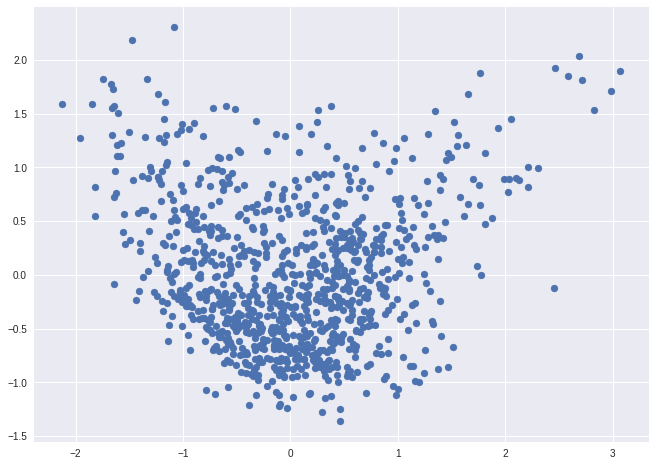

In [25]:
from sklearn.decomposition import PCA

pca = PCA().fit_transform(matrix)
ax = plt.subplot(aspect='equal')

ax.scatter(pca[:,0], pca[:,1])
 

### tSNE

tSNE is a dimensionality reduction technique useful for visualizing high-dimensional data  

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE  

https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm  


The **learning rate** can be a critical parameter. It should be between 100 and 1000. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high. If the cost function gets stuck in a bad local minimum increasing the learning rate helps sometimes  

**random_state** is Pseudo Random Number generator seed control.   
If None, use the numpy.random singleton. Note that different initializations might result in different local minima of the cost function.  



[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.617742
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.077683
[t-SNE] Error after 200 iterations: 1.077683
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.197319
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.119585
[t-SNE] Error after 175 iterations: 1.119585


(<matplotlib.figure.Figure at 0x7fd312dee3d0>,
  <matplotlib.text.Text at 0x7fd312d2ff90>])

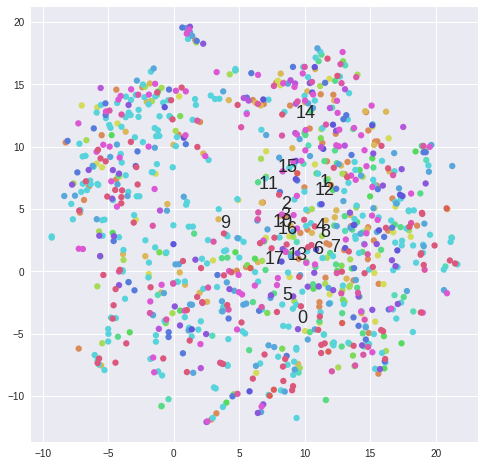

In [29]:
from sklearn.manifold import TSNE
#defaults:
#tsne = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000) #learning_rate is also called epsilon

RS = 20150101#random_state is Pseudo Random Number generator seed control. 
#If None, use the numpy.random singleton. Note that different initializations might result in different local minima of the cost function.
#tsne = TSNE(random_state=RS).fit_transform(matrix) 

#Plot first_category_name---------------------------------------------------------------------------------
matrix = data.sort("first_category_name")[samples].values
labels = np.array(data.sort("first_category_name").first_category_name)

tsne_rs = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000, random_state=RS, verbose=1).fit_transform(matrix)
tsne_cos = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000, metric='cosine', verbose=1).fit_transform(matrix)

label_color_ = {}
for i in range(len(np.unique(labels))):
	label = np.unique(labels)[i]
	label_color_[label] = i
colors = np.array([label_color_[label] for label in labels])

def scatter(x, colors, nclasses):
	palette = np.array(sb.color_palette("hls", nclasses )) # color palette with seaborn.
	f = plt.figure(figsize=(8, 8))
	ax = plt.subplot(aspect='equal')
	sc = ax.scatter(x[:,0], x[:,1], linewidth=0, s=40, color=palette[colors.astype(np.int)])
	plt.xlim(-25, 25)
	plt.ylim(-25, 25)
	#ax.axis('off')
	ax.axis('tight')
	txts = []
	for i in range(nclasses):
		# Position of each label.
		xtext, ytext = np.median(x[colors == i, :], axis=0)
		txt = ax.text(xtext, ytext, str(i), fontsize=18)
		#txt.set_path_effects([
		#	PathEffects.Stroke(linewidth=5, foreground="w"),
		#	PathEffects.Normal()])
		txts.append(txt)
	return f, ax, sc, txts

scatter(tsne_cos, colors, len(set(colors)))

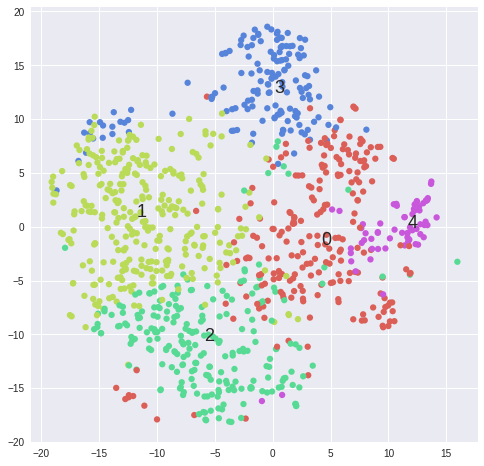

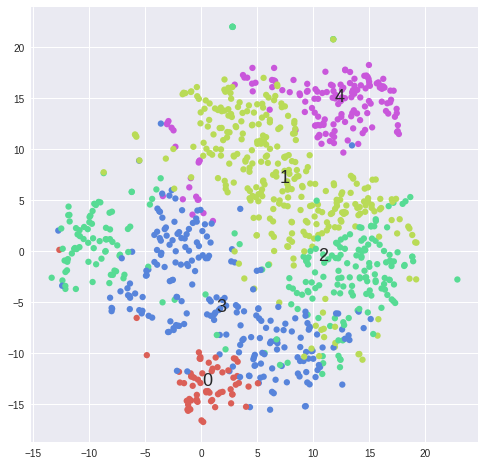

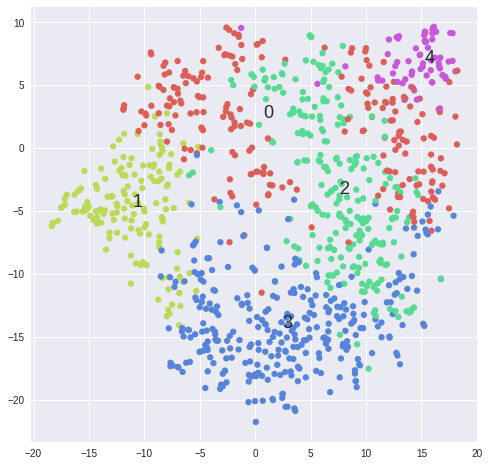

In [30]:
#Plot clusters from k-means ------------------------------------------------------------------------------------------------
matrix =  2**data[samples].values
for k in range(2,5):
	kmeans = KMeans(n_clusters=5, init='k-means++')#, random_state=10) 
	cluster_labels = kmeans.fit_predict(matrix)
	tsne = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000, metric='cosine', verbose=0).fit_transform(matrix)
	scatter(tsne, cluster_labels, len(set(cluster_labels)))